In [1]:
import pandas as pd

# Read the CSV file into a DataFrame
import pandas as pd


df = pd.read_csv('k221.csv')
df1 = pd.read_csv('k300.csv')
df2 = pd.read_csv('k500.csv')
df3 = pd.read_csv('k800.csv')
df4 = pd.read_csv('k1000.csv')




## Check for Diveristy Issue
## Identify sensitive_attributes

In [2]:
#this function check the minimun number of unique values of certain features and their minimun normalised entrophy among all of the equivalent classes
#provide warming if one attributes in one equivalant class is below the entrophy threhold 

import pandas as pd
import numpy as np

def check_entropy_l_diversity(df, quasi_identifiers, sensitive_attributes, entropy_threshold):
    """
    Check and generate warnings for attributes below entropy threshold within each equivalence class,
    and provide a summary of minimum normalized entropy and unique values.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        quasi_identifiers (list): Columns defining equivalence classes.
        sensitive_attributes (list): Sensitive attributes to assess.
        entropy_threshold (float): Threshold for acceptable normalized entropy.
    
    Returns:
        pd.DataFrame: Warnings for each equivalence class where entropy is below the threshold.
        pd.DataFrame: Summary data showing minimum l-values and normalized entropy.
    """
    grouped = df.groupby(quasi_identifiers)
    warnings_data = []
    min_l_values = {attr: float('inf') for attr in sensitive_attributes}
    min_entropy_values = {attr: float('inf') for attr in sensitive_attributes}
    distinct_values_count = {attr: 0 for attr in sensitive_attributes}

    # Helper function to calculate normalized entropy
    def calculate_normalized_entropy(series):
        probabilities = series.value_counts(normalize=True)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        max_entropy = np.log2(len(probabilities)) if len(probabilities) > 0 else 1
        return entropy / max_entropy if max_entropy else 0

    for group_key, group_df in grouped:
        for attribute in sensitive_attributes:
            unique_count = group_df[attribute].nunique()
            normalized_entropy = calculate_normalized_entropy(group_df[attribute])
            distinct_values_count[attribute] = df[attribute].nunique()
            if unique_count < min_l_values[attribute]:
                min_l_values[attribute] = unique_count
            if normalized_entropy < min_entropy_values[attribute]:
                min_entropy_values[attribute] = normalized_entropy
            
            # Generate warning if the normalized entropy is below threshold
            if normalized_entropy < entropy_threshold:
                warnings_data.append({
                    'Equivalence Class': ', '.join(map(str, group_key)),
                    'Attribute': attribute,
                    'Normalized Entropy': normalized_entropy,
                    'Warning': f"Entropy below threshold: {normalized_entropy:.3f} (threshold: {entropy_threshold})"
                })

    warnings_df = pd.DataFrame(warnings_data)
    if warnings_df.empty:
        warnings_df = pd.DataFrame(columns=['Equivalence Class', 'Attribute', 'Normalized Entropy', 'Warning'])
        warnings_df.loc[0] = ["No classes", "N/A", "N/A", "All attributes meet entropy thresholds."]

    # Create DataFrame for summary data
    summary_data = {
        'Attribute': [],
        'Min Unique Values': [],
        'Min Normalized Entropy': [],
        'Distinct Values': []
    }
    for attribute, min_val in min_l_values.items():
        summary_data['Attribute'].append(attribute)
        summary_data['Min Unique Values'].append(min_val)
        summary_data['Min Normalized Entropy'].append(min_entropy_values[attribute])
        summary_data['Distinct Values'].append(distinct_values_count[attribute])

    summary_df = pd.DataFrame(summary_data)

    return warnings_df, summary_df

# Example usage
quasi_identifiers = ['race', 'gender', 'age']
sensitive_attributes = ['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'readmitted']
entropy_threshold = 0.25

# Assuming 'df' is your DataFrame containing the data
warnings_report, summary_report = check_entropy_l_diversity(df, quasi_identifiers, sensitive_attributes, entropy_threshold)

# Displaying the reports
print("\nSummary of Minimum l Values and Entropy:")
print(summary_report)

print("\nEntropy Warnings Report:")
print(warnings_report)



Summary of Minimum l Values and Entropy:
       Attribute  Min Unique Values  Min Normalized Entropy  Distinct Values
0         diag_1                  8                0.606566               10
1         diag_2                  8                0.562586               10
2         diag_3                  8                0.674722               10
3  max_glu_serum                  3                0.067771                4
4      A1Cresult                  4                0.361971                4
5     readmitted                  2                0.285435                2

Entropy Warnings Report:
                    Equivalence Class      Attribute  Normalized Entropy  \
0     AfricanAmerican, Female, [0-40)  max_glu_serum            0.067771   
1    AfricanAmerican, Female, [40-50)  max_glu_serum            0.115360   
2    AfricanAmerican, Female, [50-60)  max_glu_serum            0.073586   
3    AfricanAmerican, Female, [60-70)  max_glu_serum            0.085473   
4    AfricanA

## Entropy l diveristy

Normalized Entropy:

Normalized entropy is computed by dividing the actual entropy by the maximum possible entropy (i.e., the entropy that would occur if every category were equally likely).
Formula: 
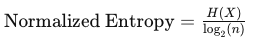
 
The result is a value between 0 and 1:
1 indicates perfect uniformity (maximum diversity, where all outcomes are equally probable).
0 indicates no diversity at all (a single outcome dominates completely).
Values near 0 indicate that the data is highly skewed towards one or a few outcomes.
Higher values closer to 1 indicate greater diversity and lesser predictability.

In [3]:
#More Detailed Normalized Entropy L-Diversity Report with Warnings

def entropy_l_diversity_report(df, quasi_identifiers, sensitive_attributes, entropy_threshold=0.5):
    """
    Generate a detailed report per equivalence class showing the normalized entropy l-diversity value for all selected sensitive attributes.
    Also includes warnings if any sensitive attribute has normalized entropy below the specified threshold.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        quasi_identifiers (list): The list of columns defining equivalence classes.
        sensitive_attributes (list): The list of sensitive attributes to assess entropy l-diversity.
        entropy_threshold (float): The minimum required normalized entropy value for each sensitive attribute.
    
    Returns:
        pd.DataFrame: A detailed DataFrame with normalized entropy values per equivalence class and per sensitive attribute.
    """
    # Group by quasi-identifiers to form equivalence classes
    grouped = df.groupby(quasi_identifiers)

    # List to collect entropy values per equivalence class
    report_data = []

    # Function to calculate normalized entropy given a series of values
    def calculate_normalized_entropy(series):
        probabilities = series.value_counts(normalize=True)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        max_entropy = np.log2(len(probabilities)) if len(probabilities) > 0 else 1
        return entropy / max_entropy if max_entropy else 0  # Normalize the entropy

    # Iterate through each group (equivalence class)
    for group_key, group_df in grouped:
        # Initialize an empty dictionary to store details for each equivalence class
        class_info = dict(zip(quasi_identifiers, group_key))
        
        # Initialize a list to collect warnings for the current equivalence class
        warnings = []

        # Calculate the normalized entropy for each sensitive attribute in this class
        for sensitive_attribute in sensitive_attributes:
            entropy_value = calculate_normalized_entropy(group_df[sensitive_attribute])
            class_info[f'{sensitive_attribute} - Normalized Entropy'] = entropy_value

            # Find the most frequent value(s) for this attribute
            dominant_value_counts = group_df[sensitive_attribute].value_counts()
            dominant_value = dominant_value_counts.index[0]
            dominant_count = dominant_value_counts.iloc[0]
            class_info[f'{sensitive_attribute} - Dominant Value'] = dominant_value
            class_info[f'{sensitive_attribute} - Dominant Count'] = dominant_count

            # Add a warning if the normalized entropy is below the specified threshold
            if entropy_value < entropy_threshold:
                warnings.append(f"{sensitive_attribute} normalized entropy is {entropy_value:.3f}, below {entropy_threshold}. Dominant value: {dominant_value} with count {dominant_count}")

        # Add warnings to the report for this equivalence class
        class_info['Warnings'] = "; ".join(warnings) if warnings else "No diversity issues"

        # Collect all the entropy values in this class for reporting
        report_data.append(class_info)

    # Convert the collected data to a DataFrame for easier analysis
    return pd.DataFrame(report_data)

# Example usage:

# Define the quasi-identifiers and sensitive attributes
quasi_identifiers = ['race', 'gender', 'age']
sensitive_attributes = ['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'readmitted']

detailed_report = entropy_l_diversity_report(df, quasi_identifiers, sensitive_attributes, entropy_threshold=0.25)

# Display the detailed report
print("\nNormalized Entropy L-Diversity Report with Warnings:")
detailed_report



Normalized Entropy L-Diversity Report with Warnings:


,race,gender,age,diag_1 - Normalized Entropy,diag_1 - Dominant Value,diag_1 - Dominant Count,diag_2 - Normalized Entropy,diag_2 - Dominant Value,diag_2 - Dominant Count,diag_3 - Normalized Entropy,...,max_glu_serum - Normalized Entropy,max_glu_serum - Dominant Value,max_glu_serum - Dominant Count,A1Cresult - Normalized Entropy,A1Cresult - Dominant Value,A1Cresult - Dominant Count,readmitted - Normalized Entropy,readmitted - Dominant Value,readmitted - Dominant Count,Warnings
0,AfricanAmerican,Female,[0-40),0.718071,other,604,0.696027,other,655,0.734184,...,0.067771,0,1245,0.595818,0,899,0.492619,0,1128,"max_glu_serum normalized entropy is 0.068, bel..."
1,AfricanAmerican,Female,[40-50),0.800054,other,543,0.740319,other,651,0.760331,...,0.115360,0,1503,0.474670,0,1257,0.524436,0,1364,"max_glu_serum normalized entropy is 0.115, bel..."
2,AfricanAmerican,Female,[50-60),0.826443,circulatory,689,0.773739,other,840,0.771467,...,0.073586,0,2416,0.486961,0,1982,0.448406,0,2227,"max_glu_serum normalized entropy is 0.074, bel..."
3,AfricanAmerican,Female,[60-70),0.827115,circulatory,793,0.760154,circulatory,898,0.770731,...,0.085473,0,2381,0.397894,0,2088,0.499680,0,2162,"max_glu_serum normalized entropy is 0.085, bel..."
4,AfricanAmerican,Female,[70-80),0.809295,circulatory,887,0.764972,circulatory,878,0.758071,...,0.103420,0,2388,0.414324,0,2092,0.537518,0,2149,"max_glu_serum normalized entropy is 0.103, bel..."
5,AfricanAmerican,Female,[80-100),0.853621,circulatory,508,0.719521,circulatory,586,0.746371,...,0.104294,0,1541,0.361971,0,1389,0.517018,0,1398,"max_glu_serum normalized entropy is 0.104, bel..."
6,AfricanAmerican,Male,[0-40),0.606566,other,457,0.562586,other,474,0.674722,...,0.110076,0,704,0.644674,0,488,0.529837,0,637,"max_glu_serum normalized entropy is 0.110, bel..."
7,AfricanAmerican,Male,[40-50),0.770948,other,469,0.691128,other,565,0.731808,...,0.153275,0,1190,0.583389,0,918,0.532136,0,1090,"max_glu_serum normalized entropy is 0.153, bel..."
8,AfricanAmerican,Male,[50-60),0.800384,circulatory,575,0.751289,other,646,0.755211,...,0.091531,0,1728,0.517040,0,1397,0.480014,0,1585,"max_glu_serum normalized entropy is 0.092, bel..."
9,AfricanAmerican,Male,[60-70),0.796608,circulatory,654,0.764534,circulatory,687,0.762423,...,0.117123,0,1749,0.428711,0,1522,0.531970,0,1585,"max_glu_serum normalized entropy is 0.117, bel..."


# Achiveing L-diveristy through suppression /deleting data /adding sythetic data

# Deleting for l-diveristy

In [16]:
# Experiment under the different value for l=0.25,0.3,0.35
import pandas as pd
import numpy as np

def achieve_entropy_l_diversity_by_deletion(df, quasi_identifiers, sensitive_attributes, entropy_threshold):
    """
    Modify the DataFrame to ensure each equivalence class satisfies normalized entropy l-diversity
    by deleting rows that do not meet the threshold and provide information about data loss and 
    minimum normalized entropy l-values.
    
    Args:
        df (pd.DataFrame): The DataFrame to modify.
        quasi_identifiers (list): Columns defining equivalence classes.
        sensitive_attributes (list): Sensitive attributes to anonymize.
        entropy_threshold (float): Threshold for acceptable normalized entropy.
    
    Returns:
        pd.DataFrame: Modified DataFrame satisfying entropy l-diversity.
        dict: Information about the data loss and minimum normalized entropy l-values.
    """
    def calculate_normalized_entropy(series):
        probabilities = series.value_counts(normalize=True)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        max_entropy = np.log2(len(probabilities)) if len(probabilities) > 0 else 1
        return entropy / max_entropy if max_entropy else 0

    # Create a copy of the dataframe to avoid modifying the original one
    modified_df = df.copy()
    grouped = modified_df.groupby(quasi_identifiers)
    
    rows_to_delete = []
    min_normalized_entropies = {attribute: float('inf') for attribute in sensitive_attributes}

    for group_key, group_df in grouped:
        for attribute in sensitive_attributes:
            normalized_entropy = calculate_normalized_entropy(group_df[attribute])
            
            while normalized_entropy < entropy_threshold and not group_df.empty:
                # Find the row with the highest frequency for this attribute and mark it for deletion
                most_common_value = group_df[attribute].value_counts().idxmax()
                row_to_delete = group_df[group_df[attribute] == most_common_value].index[0]
                rows_to_delete.append(row_to_delete)
                group_df = group_df.drop(row_to_delete)
                
                # Recalculate entropy after deletion
                normalized_entropy = calculate_normalized_entropy(group_df[attribute])
            
            # Update the minimum normalized entropy for this attribute
            if normalized_entropy < min_normalized_entropies[attribute]:
                min_normalized_entropies[attribute] = normalized_entropy
    
    # Drop the marked rows from the dataframe
    modified_df = modified_df.drop(rows_to_delete)
    
    # Calculate data loss information
    original_row_count = len(df)
    modified_row_count = len(modified_df)
    rows_deleted = original_row_count - modified_row_count
    data_loss_percentage = (rows_deleted / original_row_count) * 100

    data_loss_info = {
        'Original Row Count': original_row_count,
        'Modified Row Count': modified_row_count,
        'Rows Deleted': rows_deleted,
        'Data Loss Percentage': data_loss_percentage,
        'Min Normalized Entropies': min_normalized_entropies
    }
    
    return modified_df, data_loss_info

# Example usage
quasi_identifiers = ['race', 'gender', 'age']
sensitive_attributes = ['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'readmitted']
entropy_threshold = 0.25

# Assuming 'df' is your DataFrame containing the data
modified_df, data_loss_info = achieve_entropy_l_diversity_by_deletion(df, quasi_identifiers, sensitive_attributes, entropy_threshold)

# Displaying the modified DataFrame and data loss information
print("Modified DataFrame:")
print(modified_df)

print("\nData Loss Information:")
print(data_loss_info)


Modified DataFrame:
        encounter_id  patient_nbr             race  gender       age  \
8              12522     48330783        Caucasian  Female  [80-100)   
9              15738     63555939        Caucasian  Female  [80-100)   
23            183930    107400762        Caucasian  Female  [80-100)   
29            252822     18196434        Caucasian  Female  [80-100)   
44            450210     80177094        Caucasian  Female  [80-100)   
...              ...          ...              ...     ...       ...   
101758     443847548    100162476  AfricanAmerican    Male   [70-80)   
101759     443847782     74694222  AfricanAmerican  Female  [80-100)   
101760     443854148     41088789        Caucasian    Male   [70-80)   
101761     443857166     31693671        Caucasian  Female  [80-100)   
101762     443867222    175429310        Caucasian    Male   [70-80)   

        admission_type_id discharge_disposition_id admission_source_id  \
8                       1                

In [17]:
output_path = "l025.csv"


modified_df.to_csv(output_path, index=False)

In [19]:
quasi_identifiers = ['race', 'gender', 'age']
sensitive_attributes = ['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'readmitted']
entropy_threshold = 0.3

# Assuming 'df' is your DataFrame containing the data
modified_df, data_loss_info = achieve_entropy_l_diversity_by_deletion(df, quasi_identifiers, sensitive_attributes, entropy_threshold)

# Displaying the modified DataFrame and data loss information
print("Modified DataFrame:")
print(modified_df)

print("\nData Loss Information:")
print(data_loss_info)


Modified DataFrame:
        encounter_id  patient_nbr             race  gender       age  \
133          2265486     44279478        Caucasian    Male   [70-80)   
135          2292606     53848278  AfricanAmerican  Female   [70-80)   
142          2309268     77475465        Caucasian  Female  [80-100)   
144          2311404     95586993        Caucasian  Female  [80-100)   
153          2430276     69318126        Caucasian    Male   [70-80)   
...              ...          ...              ...     ...       ...   
101758     443847548    100162476  AfricanAmerican    Male   [70-80)   
101759     443847782     74694222  AfricanAmerican  Female  [80-100)   
101760     443854148     41088789        Caucasian    Male   [70-80)   
101761     443857166     31693671        Caucasian  Female  [80-100)   
101762     443867222    175429310        Caucasian    Male   [70-80)   

        admission_type_id discharge_disposition_id admission_source_id  \
133                     0                

In [20]:
output_path = "l03.csv"


modified_df.to_csv(output_path, index=False)

In [21]:
quasi_identifiers = ['race', 'gender', 'age']
sensitive_attributes = ['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'readmitted']
entropy_threshold = 0.35

# Assuming 'df' is your DataFrame containing the data
modified_df, data_loss_info = achieve_entropy_l_diversity_by_deletion(df, quasi_identifiers, sensitive_attributes, entropy_threshold)

# Displaying the modified DataFrame and data loss information
print("Modified DataFrame:")
print(modified_df)

print("\nData Loss Information:")
print(data_loss_info)


Modified DataFrame:
        encounter_id  patient_nbr             race  gender       age  \
133          2265486     44279478        Caucasian    Male   [70-80)   
135          2292606     53848278  AfricanAmerican  Female   [70-80)   
142          2309268     77475465        Caucasian  Female  [80-100)   
144          2311404     95586993        Caucasian  Female  [80-100)   
153          2430276     69318126        Caucasian    Male   [70-80)   
...              ...          ...              ...     ...       ...   
101758     443847548    100162476  AfricanAmerican    Male   [70-80)   
101759     443847782     74694222  AfricanAmerican  Female  [80-100)   
101760     443854148     41088789        Caucasian    Male   [70-80)   
101761     443857166     31693671        Caucasian  Female  [80-100)   
101762     443867222    175429310        Caucasian    Male   [70-80)   

        admission_type_id discharge_disposition_id admission_source_id  \
133                     0                

In [22]:
output_path = "l035.csv"


modified_df.to_csv(output_path, index=False)

# Check the data loss

In [24]:
df1 = pd.read_csv('l025.csv')
df2 = pd.read_csv('l03.csv')
df3 = pd.read_csv('l035.csv')

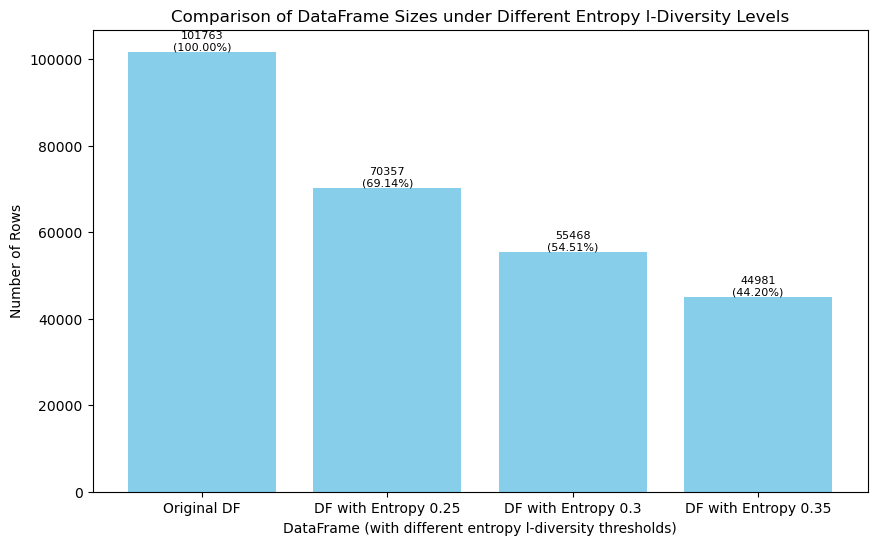

In [27]:

import matplotlib.pyplot as plt

# Example DataFrames for demonstration (assuming df1, df2, df3 are defined somewhere in your code)
dataframes = [df, df1, df2, df3]

# Corresponding names for the DataFrames (adjust to match the number of DataFrames)
df_names = ['Original DF','DF with Entropy 0.25', 'DF with Entropy 0.3', 'DF with Entropy 0.35']

# Calculate the size (number of rows) of each DataFrame
sizes = [len(df) for df in dataframes]

# Calculate the maximum size to determine percentages
max_size = max(sizes)
percentages = [(size / max_size) * 100 for size in sizes]

# Create a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(df_names, sizes, color='skyblue')  # Create a bar chart

# Add number of rows and percentage labels to each bar
for bar, size, percentage in zip(bars, sizes, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{size}\n({percentage:.2f}%)', ha='center', va='bottom', fontsize=8)

plt.xlabel('DataFrame (with different entropy l-diversity thresholds)')  # Label for the x-axis
plt.ylabel('Number of Rows')  # Label for the y-axis
plt.title('Comparison of DataFrame Sizes under Different Entropy l-Diversity Levels')  # Title of the plot
plt.show()

